# Анализ оттока клиентов банка

ТЗ

## Содержание:
1. Анализ данных и предобработка
2. Построение модели
3. Валидация
4. Сохранение модели для API

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb

import joblib
import shap

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Библиотеки успешно импортированы!")

Библиотеки успешно импортированы!


In [3]:
df = pd.read_csv('TZ.csv')

print("Размер датасета:", df.shape)
print("\nИнформация о данных:")
print(df.info())
print("\nПервые 5 строк:")
df.head()

Размер датасета: (15000, 14)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  15000 non-null  int64  
 1   ID_клиента          15000 non-null  float64
 2   фамилия             15000 non-null  object 
 3   кредитный_рейтинг   15000 non-null  float64
 4   город               15000 non-null  object 
 5   пол                 15000 non-null  object 
 6   возраст             15000 non-null  float64
 7   стаж_в_банке        15000 non-null  float64
 8   баланс_депозита     5316 non-null   float64
 9   число_продуктов     15000 non-null  float64
 10  есть_кредитка       15000 non-null  float64
 11  активный_клиент     15000 non-null  float64
 12  оценочная_зарплата  15000 non-null  float64
 13  ушел_из_банка       15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1

,ID,ID_клиента,фамилия,кредитный_рейтинг,город,пол,возраст,стаж_в_банке,баланс_депозита,число_продуктов,есть_кредитка,активный_клиент,оценочная_зарплата,ушел_из_банка
0,0,15709511.0,Тестов55,754.0,Астана,Male,40.0,8.0,102954.68,2.0,1.0,1.0,149238.35,0.0
1,1,15592761.0,Тестов539,579.0,Алматы,Female,28.0,1.0,NaN,2.0,1.0,0.0,64869.32,0.0
2,2,15579914.0,Тестов275,744.0,Алматы,Female,56.0,5.0,NaN,1.0,1.0,0.0,158816.03,1.0
3,3,15669611.0,Есенгельдиев,697.0,Алматы,Male,29.0,2.0,NaN,2.0,1.0,0.0,55775.72,0.0
4,4,15761775.0,Тестов451,628.0,Алматы,Female,22.0,9.0,NaN,2.0,1.0,0.0,49653.39,0.0


In [4]:
print("Пропущенные значения:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

print("\nПроцент пропущенных значений:")
missing_percent = (df.isnull().sum() / len(df)) * 100
print(missing_percent[missing_percent > 0])

print("\nСтатистическое описание числовых переменных:")
df.describe()

Пропущенные значения:
баланс_депозита    9684
dtype: int64

Процент пропущенных значений:
баланс_депозита    64.56
dtype: float64

Статистическое описание числовых переменных:


,ID,ID_клиента,кредитный_рейтинг,возраст,стаж_в_банке,баланс_депозита,число_продуктов,есть_кредитка,активный_клиент,оценочная_зарплата,ушел_из_банка
count,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,5316.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000
mean,7499.500000,1.579653e+07,658.851467,37.888000,5.033333,121681.886227,1.590733,0.783200,0.500200,1.181348e+05,0.203867
std,4330.271354,1.270937e+07,72.587026,8.257409,2.808359,22875.768239,0.535587,0.412079,0.500017,4.680311e+04,0.402884
min,0.000000,1.556578e+07,431.000000,18.000000,0.000000,753.370000,1.000000,0.000000,0.000000,1.158000e+01,0.000000
25%,3749.750000,1.563449e+07,602.000000,32.000000,3.000000,106392.525000,1.000000,1.000000,0.000000,8.362960e+04,0.000000
50%,7499.500000,1.569053e+07,662.000000,37.000000,5.000000,122570.690000,2.000000,1.000000,1.000000,1.235878e+05,0.000000
75%,11249.250000,1.575758e+07,709.000000,42.000000,7.000000,137226.870000,2.000000,1.000000,1.000000,1.575585e+05,0.000000
max,14999.000000,1.572242e+09,850.000000,74.000000,10.000000,187530.660000,4.000000,1.000000,1.000000,1.557802e+06,1.000000


Распределение целевой переменной 'ушел_из_банка':
ушел_из_банка
0.0    11942
1.0     3058
Name: count, dtype: int64

Процентное соотношение:
ушел_из_банка
0.0    79.613333
1.0    20.386667
Name: proportion, dtype: float64


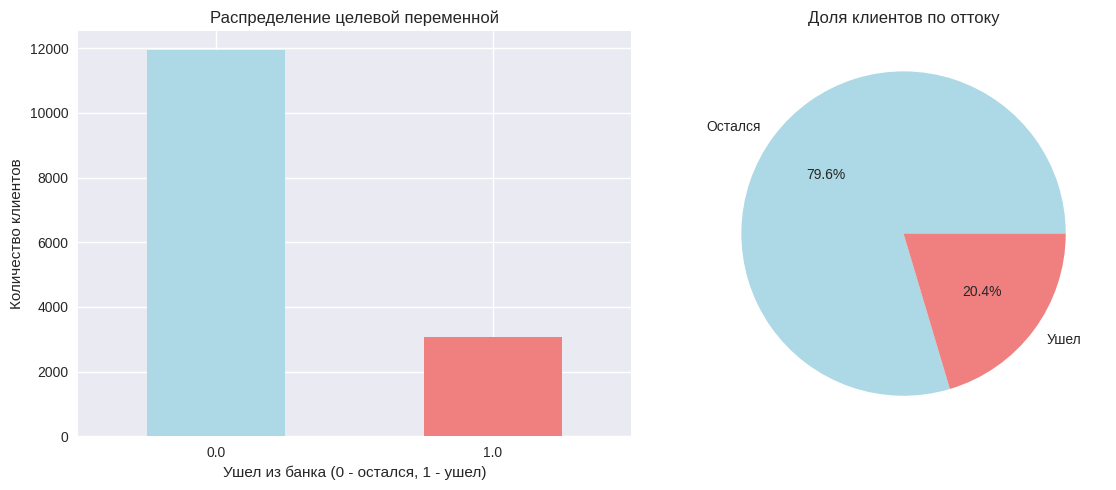


Соотношение классов: 11942/3058 = 3.91
Обнаружен дисбаланс классов - потребуется обработка


In [5]:
print("Распределение целевой переменной 'ушел_из_банка':")
target_distribution = df['ушел_из_банка'].value_counts()
print(target_distribution)
print(f"\nПроцентное соотношение:")
print(df['ушел_из_банка'].value_counts(normalize=True) * 100)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['ушел_из_банка'].value_counts().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Распределение целевой переменной')
plt.xlabel('Ушел из банка (0 - остался, 1 - ушел)')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(df['ушел_из_банка'].value_counts(), labels=['Остался', 'Ушел'],
        autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Доля клиентов по оттоку')

plt.tight_layout()
plt.show()

# Проверка на дисбаланс классов
print(f"\nСоотношение классов: {target_distribution[0]}/{target_distribution[1]} = {target_distribution[0]/target_distribution[1]:.2f}")
if target_distribution[0]/target_distribution[1] > 3 or target_distribution[1]/target_distribution[0] > 3:
    print("Обнаружен дисбаланс классов - потребуется обработка")

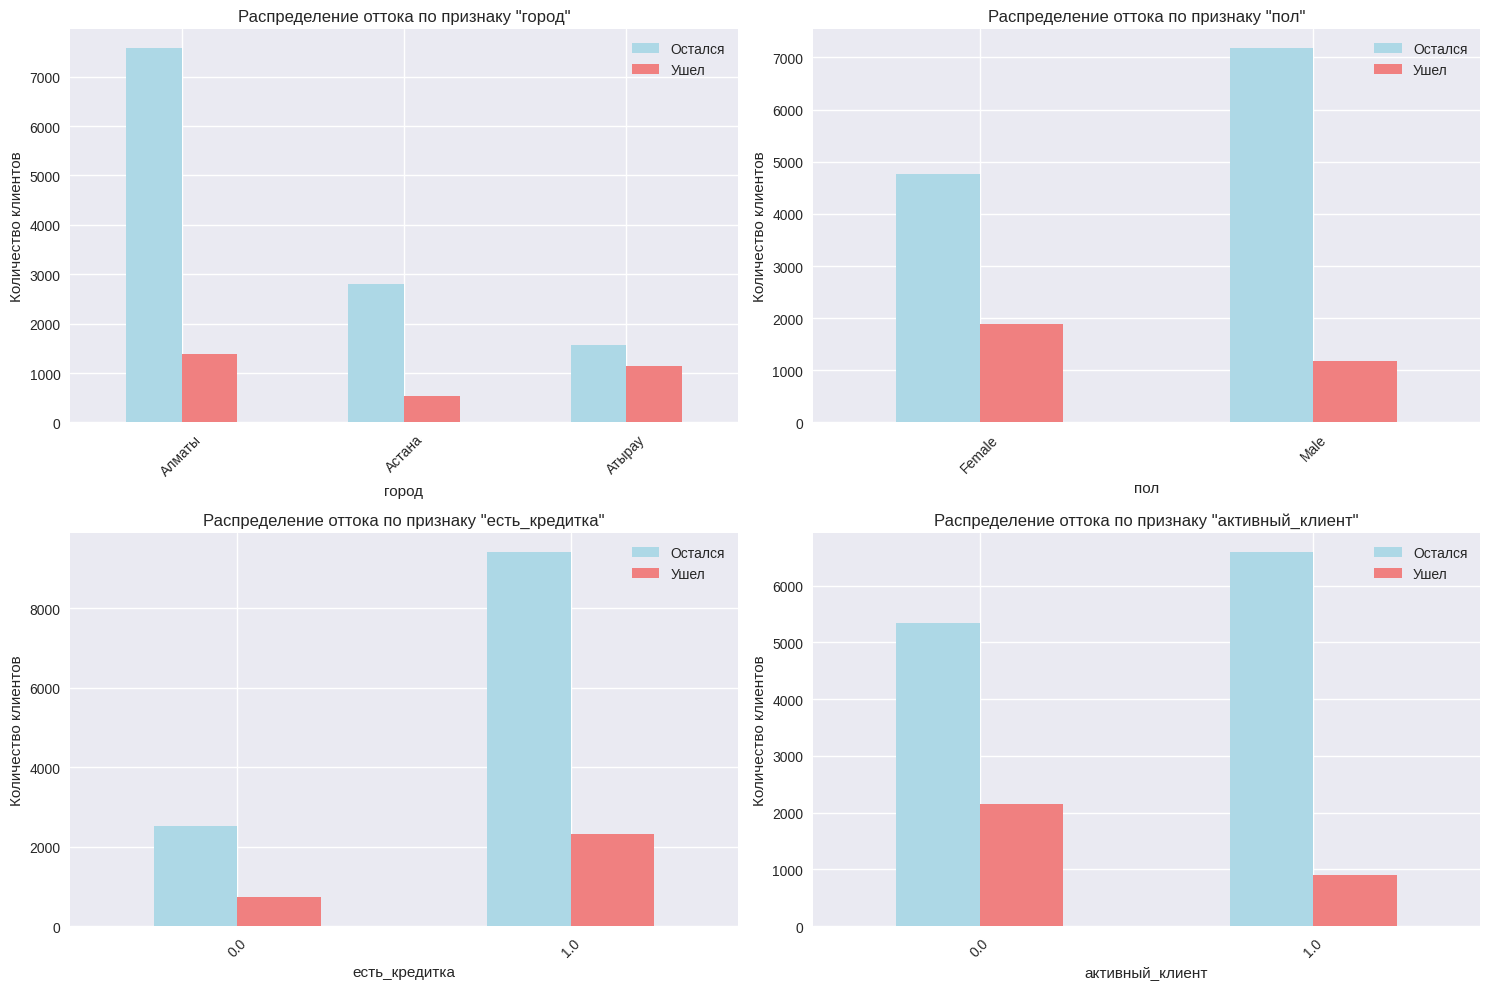

In [6]:
# Анализ категориальных переменных
categorical_cols = ['город', 'пол', 'есть_кредитка', 'активный_клиент']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    df_grouped = df.groupby([col, 'ушел_из_банка']).size().unstack()
    df_grouped.plot(kind='bar', ax=plt.gca(), color=['lightblue', 'lightcoral'])
    plt.title(f'Распределение оттока по признаку "{col}"')
    plt.xlabel(col)
    plt.ylabel('Количество клиентов')
    plt.legend(['Остался', 'Ушел'])
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

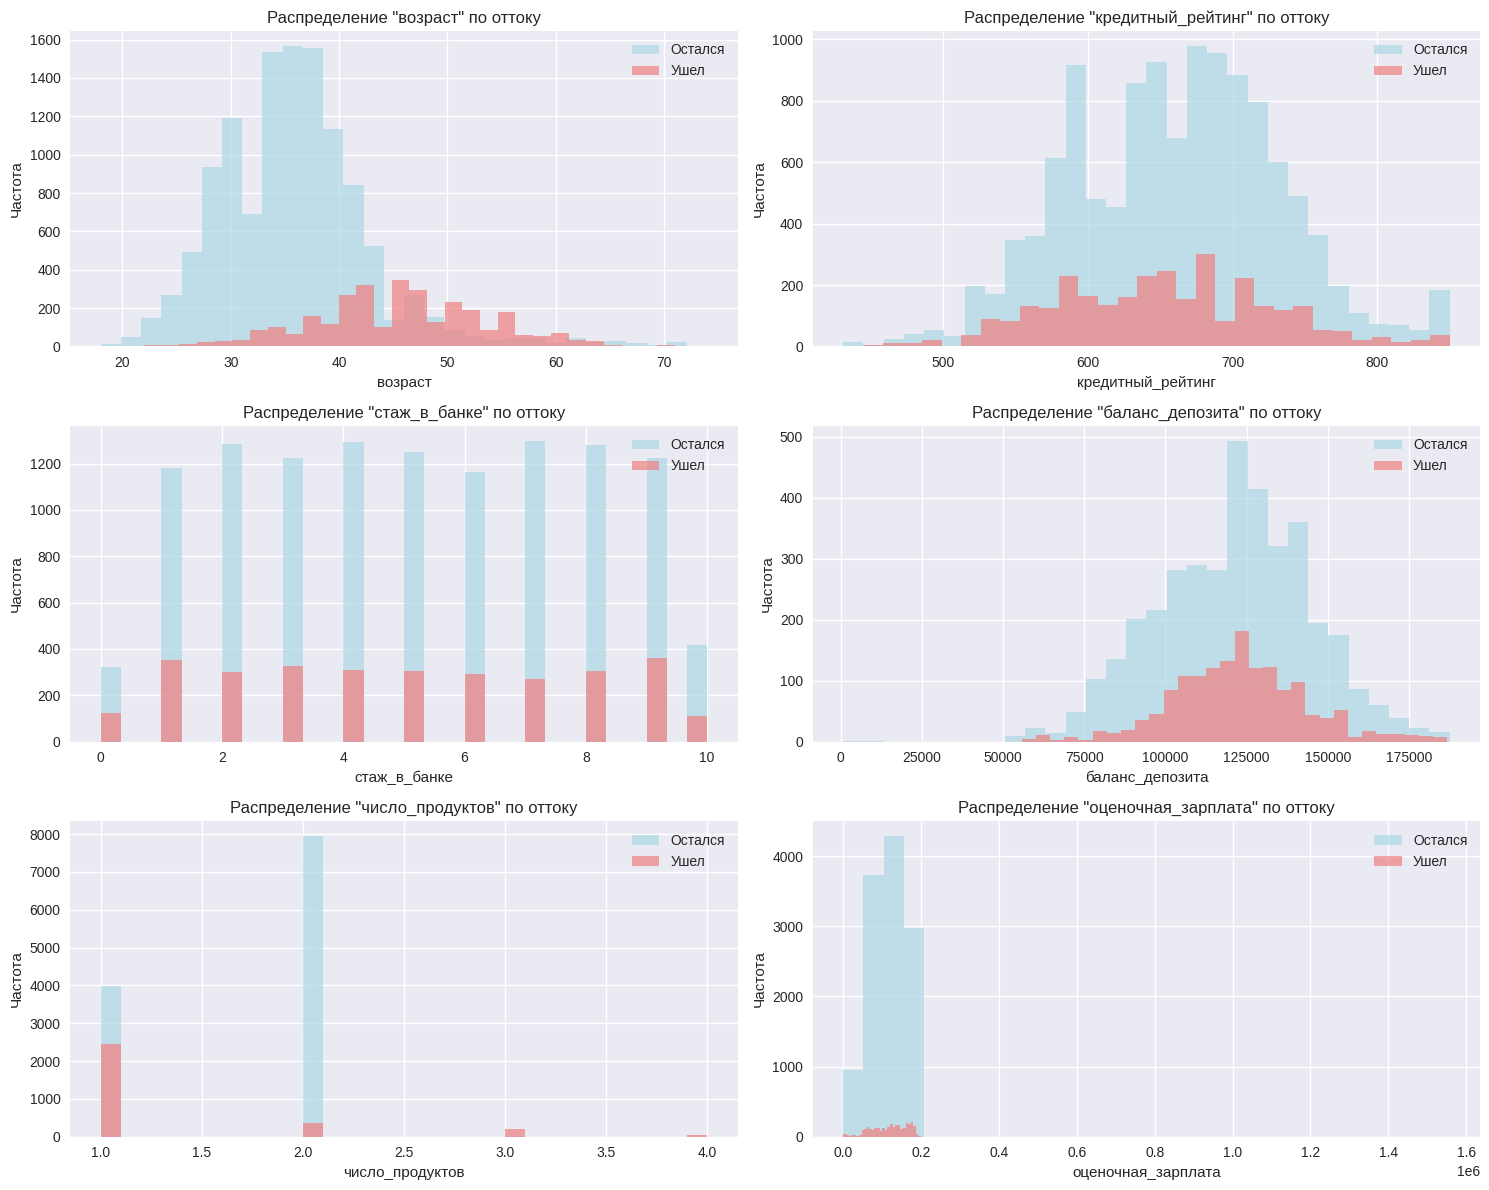

In [7]:
# Анализ числовых переменных
numerical_cols = ['возраст', 'кредитный_рейтинг', 'стаж_в_банке', 'баланс_депозита',
                 'число_продуктов', 'оценочная_зарплата']

plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    df[df['ушел_из_банка']==0][col].hist(alpha=0.7, label='Остался', bins=30, color='lightblue')
    df[df['ушел_из_банка']==1][col].hist(alpha=0.7, label='Ушел', bins=30, color='lightcoral')
    plt.title(f'Распределение "{col}" по оттоку')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.legend()

plt.tight_layout()
plt.show()

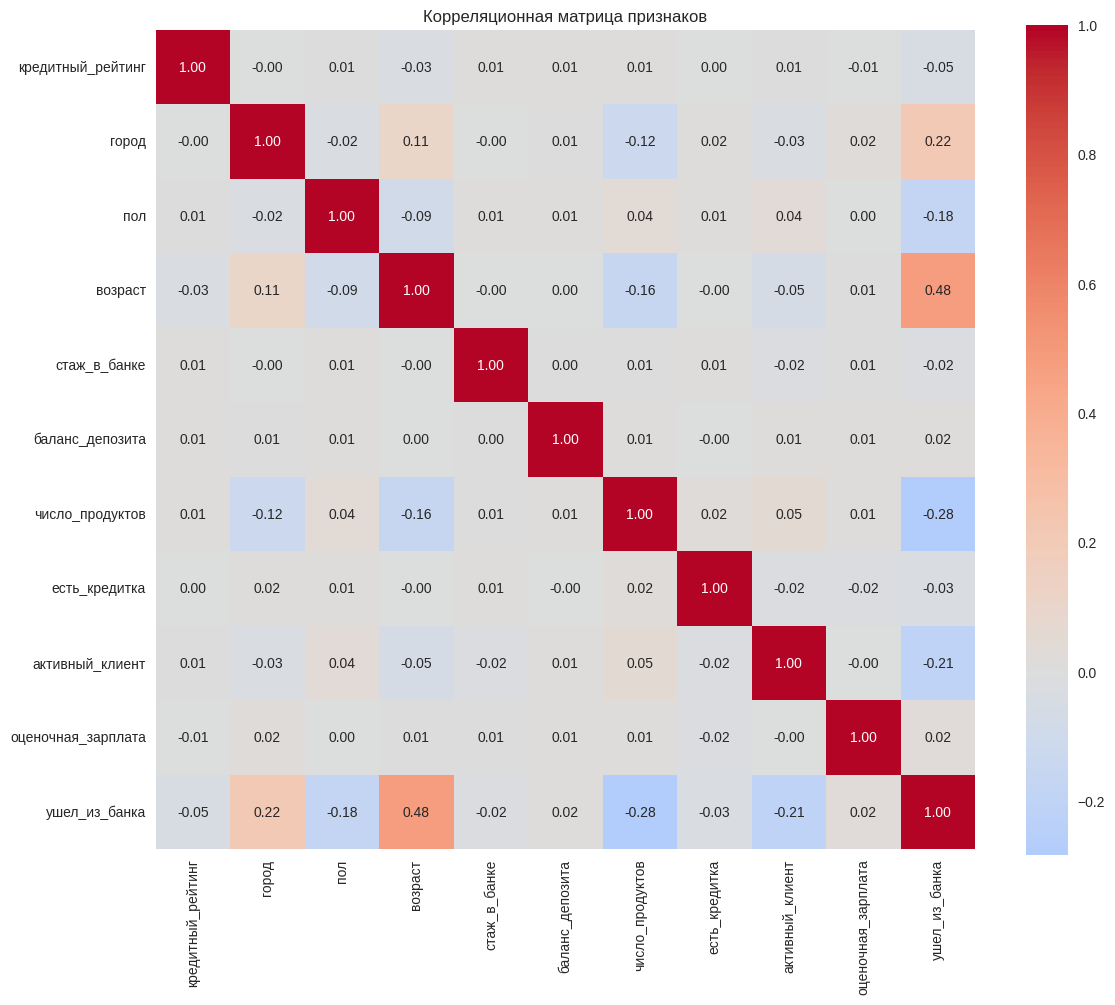

Корреляция признаков с целевой переменной 'ушел_из_банка':
возраст               0.481368
число_продуктов       0.282240
город                 0.217308
активный_клиент       0.205727
пол                   0.175207
кредитный_рейтинг     0.045404
есть_кредитка         0.028121
оценочная_зарплата    0.023511
баланс_депозита       0.015406
стаж_в_банке          0.015022
Name: ушел_из_банка, dtype: float64


In [8]:
# Корреляционный анализ
df_corr = df.copy()

cols_to_drop = ['ID', 'ID_клиента', 'фамилия']
df_corr = df_corr.drop(cols_to_drop, axis=1)

le = LabelEncoder()
for col in ['город', 'пол']:
    df_corr[col] = le.fit_transform(df_corr[col].astype(str))

# Заполняем пропущенные значения медианой для корреляционного анализа
df_corr = df_corr.fillna(df_corr.median())

plt.figure(figsize=(12, 10))
correlation_matrix = df_corr.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Корреляционная матрица признаков')
plt.tight_layout()
plt.show()

print("Корреляция признаков с целевой переменной 'ушел_из_банка':")
target_corr = correlation_matrix['ушел_из_банка'].abs().sort_values(ascending=False)
print(target_corr[1:])

In [27]:
# Предобработка данных
df_processed = df.copy()

columns_to_drop = ['ID', 'ID_клиента', 'фамилия']
df_processed = df_processed.drop(columns_to_drop, axis=1)

print("Столбцы после удаления неинформативных:")
print(df_processed.columns.tolist())

print(f"\nПропущенные значения до обработки:")
print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0])

# Заполняем пропущенные значения
# Для баланса депозита - медианой
print("Медиана баланc_депозита:", df_processed['баланс_депозита'].median())
df_processed['баланс_депозита'].fillna(df_processed['баланс_депозита'].median(), inplace=True)

print(f"\nПропущенные значения после обработки:")
print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0])

# One-hot encoding для города
df_processed = pd.get_dummies(df_processed, columns=['город'], prefix='город')

# Label encoding для пола (бинарная переменная)
le_gender = LabelEncoder()
df_processed['пол'] = le_gender.fit_transform(df_processed['пол'])

print(f"\nРазмер данных после предобработки: {df_processed.shape}")
print("\nСтолбцы после предобработки:")
print(df_processed.columns.tolist())

Столбцы после удаления неинформативных:
['кредитный_рейтинг', 'город', 'пол', 'возраст', 'стаж_в_банке', 'баланс_депозита', 'число_продуктов', 'есть_кредитка', 'активный_клиент', 'оценочная_зарплата', 'ушел_из_банка']

Пропущенные значения до обработки:
баланс_депозита    9684
dtype: int64
Медиана баланc_депозита: 122570.69

Пропущенные значения после обработки:
Series([], dtype: int64)

Размер данных после предобработки: (15000, 13)

Столбцы после предобработки:
['кредитный_рейтинг', 'пол', 'возраст', 'стаж_в_банке', 'баланс_депозита', 'число_продуктов', 'есть_кредитка', 'активный_клиент', 'оценочная_зарплата', 'ушел_из_банка', 'город_Алматы', 'город_Астана', 'город_Атырау']


In [10]:
X = df_processed.drop('ушел_из_банка', axis=1)
y = df_processed['ушел_из_банка']

print("Форма признаков X:", X.shape)
print("Форма целевой переменной y:", y.shape)
print("\nПризнаки:")
print(X.columns.tolist())

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазмеры выборок:")
print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Распределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))
print(f"Распределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\nДанные успешно подготовлены для обучения моделей!")

Форма признаков X: (15000, 12)
Форма целевой переменной y: (15000,)

Признаки:
['кредитный_рейтинг', 'пол', 'возраст', 'стаж_в_банке', 'баланс_депозита', 'число_продуктов', 'есть_кредитка', 'активный_клиент', 'оценочная_зарплата', 'город_Алматы', 'город_Астана', 'город_Атырау']

Размеры выборок:
Обучающая выборка: (12000, 12)
Тестовая выборка: (3000, 12)
Распределение классов в обучающей выборке:
ушел_из_банка
0.0    0.796167
1.0    0.203833
Name: proportion, dtype: float64
Распределение классов в тестовой выборке:
ушел_из_банка
0.0    0.796
1.0    0.204
Name: proportion, dtype: float64

Данные успешно подготовлены для обучения моделей!


In [15]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
}

results = {}

print("Обучение и оценка базовых моделей:\n")

for name, model in models.items():
    print(f"Обучение модели: {name}")


    if name in ['Logistic Regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    gini = 2 * roc_auc - 1
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Кросс-валидация
    if name in ['Logistic Regression']:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    results[name] = {
        'ROC-AUC': roc_auc,
        'Gini': gini,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Model': model,
        'Predictions': y_pred_proba
    }

    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  Gini: {gini:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  CV ROC-AUC: {cv_scores.mean():.4f}")
    print()

# Сравнение моделей
print("Сравнение моделей:")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC-AUC': [results[model]['ROC-AUC'] for model in results.keys()],
    'Gini': [results[model]['Gini'] for model in results.keys()],
    'Precision': [results[model]['Precision'] for model in results.keys()],
    'Recall': [results[model]['Recall'] for model in results.keys()],
    'F1-Score': [results[model]['F1-Score'] for model in results.keys()],
    'CV Mean': [results[model]['CV Mean'] for model in results.keys()]
})

print(comparison_df.round(4))

Обучение и оценка базовых моделей:

Обучение модели: Logistic Regression
  ROC-AUC: 0.8809
  Gini: 0.7617
  Precision: 0.7443
  Recall: 0.5376
  F1-Score: 0.6243
  CV ROC-AUC: 0.8858

Обучение модели: Random Forest
  ROC-AUC: 0.9225
  Gini: 0.8450
  Precision: 0.7791
  Recall: 0.6340
  F1-Score: 0.6991
  CV ROC-AUC: 0.9194

Обучение модели: XGBoost
  ROC-AUC: 0.9216
  Gini: 0.8433
  Precision: 0.7537
  Recall: 0.6699
  F1-Score: 0.7093
  CV ROC-AUC: 0.9170

Обучение модели: LightGBM
  ROC-AUC: 0.9300
  Gini: 0.8599
  Precision: 0.7771
  Recall: 0.6667
  F1-Score: 0.7177
  CV ROC-AUC: 0.9291

Сравнение моделей:
                 Model  ROC-AUC    Gini  Precision  Recall  F1-Score  CV Mean
0  Logistic Regression   0.8809  0.7617     0.7443  0.5376    0.6243   0.8858
1        Random Forest   0.9225  0.8450     0.7791  0.6340    0.6991   0.9194
2              XGBoost   0.9216  0.8433     0.7537  0.6699    0.7093   0.9170
3             LightGBM   0.9300  0.8599     0.7771  0.6667    0.7177  

In [17]:
# Подбор гиперпараметров для лучшей модели
best_model_name = max(results, key=lambda x: results[x]['ROC-AUC'])
print(f"Лучшая базовая модель: {best_model_name}")
print(f"ROC-AUC: {results[best_model_name]['ROC-AUC']:.4f}")
print(f"GINI: {results[best_model_name]['Gini']:.4f}")

print("\nПодбор гиперпараметров для LightGBM...")

param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'class_weight': [None, 'balanced']
}

lgb_grid = GridSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=-1),
    param_grid_lgb,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

lgb_grid.fit(X_train, y_train)
best_lgb = lgb_grid.best_estimator_

print(f"Лучшие параметры: {lgb_grid.best_params_}")
print(f"Лучший CV score: {lgb_grid.best_score_:.4f}")
print(f"Лучший GINI: {2 * lgb_grid.best_score_ - 1:.4f}")

print("\nПодбор гиперпараметров завершен!")

Лучшая базовая модель: LightGBM
ROC-AUC: 0.9300
GINI: 0.8599

Подбор гиперпараметров для LightGBM...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Лучшие параметры: {'class_weight': None, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
Лучший CV score: 0.9348
Лучший GINI: 0.8697

Подбор гиперпараметров завершен!


In [18]:
best_lgb

LGBMClassifier(max_depth=3, random_state=42, verbose=-1)

Финальная модель: LightGBM

Финальные метрики:
ROC-AUC: 0.9327
GINI: 0.8653835626936424
Precision: 0.8048
Recall: 0.6601
F1-Score: 0.7253


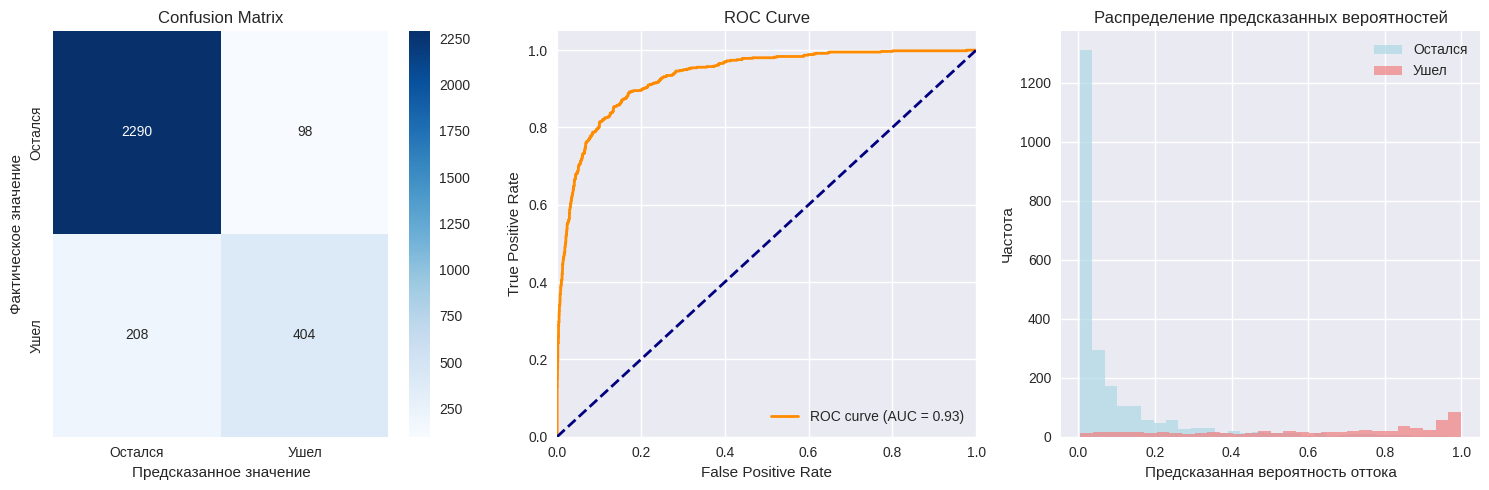


Подробный отчет по классификации:
              precision    recall  f1-score   support

     Остался       0.92      0.96      0.94      2388
        Ушел       0.80      0.66      0.73       612

    accuracy                           0.90      3000
   macro avg       0.86      0.81      0.83      3000
weighted avg       0.89      0.90      0.89      3000



In [19]:
# Оценка финальной модели
final_model = best_lgb

print(f"Финальная модель: {best_model_name}")

y_pred_final = final_model.predict(X_test)
y_pred_proba_final = final_model.predict_proba(X_test)[:, 1]

final_roc_auc = roc_auc_score(y_test, y_pred_proba_final)
final_gini = 2 * final_roc_auc - 1
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)

print(f"\nФинальные метрики:")
print(f"ROC-AUC: {final_roc_auc:.4f}")
print(f"GINI: {final_gini}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")

# Confusion Matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Остался', 'Ушел'],
            yticklabels=['Остался', 'Ушел'])
plt.title('Confusion Matrix')
plt.ylabel('Фактическое значение')
plt.xlabel('Предсказанное значение')

# ROC кривая
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_final)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {final_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Распределение предсказанных вероятностей
plt.subplot(1, 3, 3)
plt.hist(y_pred_proba_final[y_test == 0], bins=30, alpha=0.7, label='Остался', color='lightblue')
plt.hist(y_pred_proba_final[y_test == 1], bins=30, alpha=0.7, label='Ушел', color='lightcoral')
plt.xlabel('Предсказанная вероятность оттока')
plt.ylabel('Частота')
plt.title('Распределение предсказанных вероятностей')
plt.legend()

plt.tight_layout()
plt.show()

print("\nПодробный отчет по классификации:")
print(classification_report(y_test, y_pred_final, target_names=['Остался', 'Ушел']))

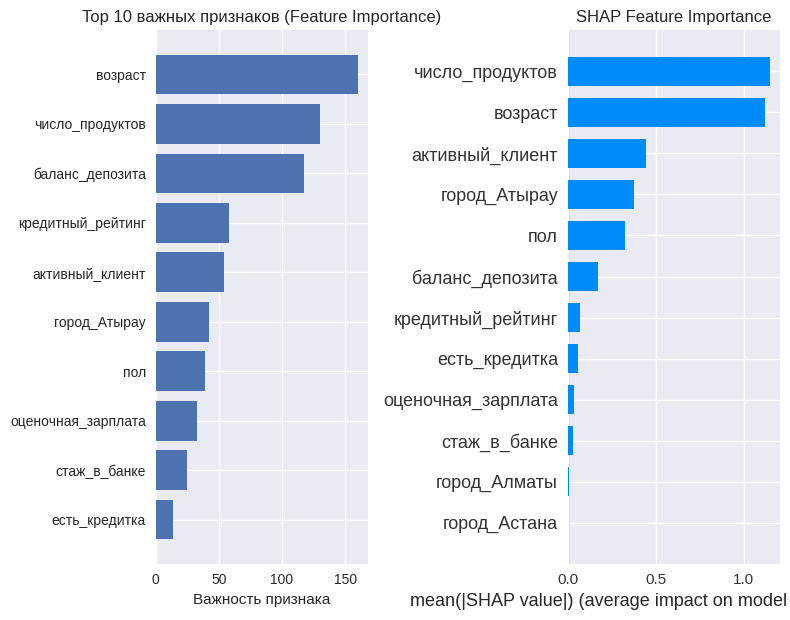

Топ-10 наиболее важных признаков:
 1. возраст: 160.0000
 2. число_продуктов: 130.0000
 3. баланс_депозита: 117.0000
 4. кредитный_рейтинг: 58.0000
 5. активный_клиент: 54.0000
 6. город_Атырау: 42.0000
 7. пол: 39.0000
 8. оценочная_зарплата: 33.0000
 9. стаж_в_банке: 25.0000
10. есть_кредитка: 14.0000


In [20]:
# Анализ важности признаков
plt.figure(figsize=(15, 6))

# Feature Importance из модели
plt.subplot(1, 2, 1)
if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.barh(range(len(feature_importance.head(10))),
             feature_importance.head(10)['importance'])
    plt.yticks(range(len(feature_importance.head(10))),
               feature_importance.head(10)['feature'])
    plt.xlabel('Важность признака')
    plt.title('Top 10 важных признаков (Feature Importance)')
    plt.gca().invert_yaxis()

# SHAP анализ
try:
    plt.subplot(1, 2, 2)
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_test.head(100))  # первые 100 образцов для скорости
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # для бинарной классификации берем положительный класс

    # Строим summary plot
    shap.summary_plot(shap_values, X_test.head(100), plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')

except Exception as e:
    plt.text(0.5, 0.5, f'SHAP анализ недоступен:\n{str(e)}',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('SHAP анализ недоступен')

plt.tight_layout()
plt.show()

if hasattr(final_model, 'feature_importances_'):
    print("Топ-10 наиболее важных признаков:")
    for i, (feature, importance) in enumerate(feature_importance.head(10).values, 1):
        print(f"{i:2}. {feature}: {importance:.4f}")
else:
    print("Данная модель не поддерживает feature_importances_")

In [24]:
# Сохранение модели и препроцессоров для API
import os
import json

models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

# Сохраняем финальную модель
model_path = os.path.join(models_dir, 'final_model.joblib')
joblib.dump(final_model, model_path)
print(f"Модель сохранена: {model_path}")

# Сохраняем энкодер для пола
le_gender_path = os.path.join(models_dir, 'label_encoder_gender.joblib')
joblib.dump(le_gender, le_gender_path)
print(f"Энкодер для пола сохранен: {le_gender_path}")

# Сохраняем информацию о столбцах
columns_info = {
    'feature_columns': X.columns.tolist(),
    'categorical_columns': ['город', 'пол'],
    'numerical_columns': ['кредитный_рейтинг', 'возраст', 'стаж_в_банке',
                          'баланс_депозита', 'число_продуктов', 'есть_кредитка',
                          'активный_клиент', 'оценочная_зарплата'],
    'model_type': best_model_name,
}

сolumns_info_path = os.path.join(models_dir, 'columns_info.json')

with open(сolumns_info_path, 'w', encoding='utf-8') as f:
    json.dump(columns_info, f, ensure_ascii=False, indent=4)

print(f"Информация о столбцах сохранена: {сolumns_info_path}")

print("\n" + "="*50)
print("ИТОГИ ТЗ")
print("="*50)
print(f"Лучшая модель: {best_model_name}")
print(f"ROC-AUC: {final_roc_auc:.4f}")
print(f"GINI: {final_gini:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")
print(f"Модель сохранена в: {model_path}")
print("="*50)

# Создаем пример для тестирования API
example_client = {
    "кредитный_рейтинг": 650,
    "город": "Алматы",
    "пол": "Male",
    "возраст": 35,
    "стаж_в_банке": 5,
    "баланс_депозита": 100000,
    "число_продуктов": 2,
    "есть_кредитка": 1,
    "активный_клиент": 1,
    "оценочная_зарплата": 120000
}

print("\nПример данных клиента для API:")
print(example_client)

Модель сохранена: models/final_model.joblib
Энкодер для пола сохранен: models/label_encoder_gender.joblib
Информация о столбцах сохранена: models/columns_info.json

ИТОГИ ТЗ
Лучшая модель: LightGBM
ROC-AUC: 0.9327
GINI: 0.8654
Precision: 0.8048
Recall: 0.6601
F1-Score: 0.7253
Модель сохранена в: models/final_model.joblib

Пример данных клиента для API:
{'кредитный_рейтинг': 650, 'город': 'Алматы', 'пол': 'Male', 'возраст': 35, 'стаж_в_банке': 5, 'баланс_депозита': 100000, 'число_продуктов': 2, 'есть_кредитка': 1, 'активный_клиент': 1, 'оценочная_зарплата': 120000}


In [33]:
json_str = json.dumps(example_client, ensure_ascii=False, indent=4)
print(json_str)

{
    "кредитный_рейтинг": 650,
    "город": "Алматы",
    "пол": "Male",
    "возраст": 35,
    "стаж_в_банке": 5,
    "баланс_депозита": 100000,
    "число_продуктов": 2,
    "есть_кредитка": 1,
    "активный_клиент": 1,
    "оценочная_зарплата": 120000
}
